In [103]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
from pathlib import Path

In [5]:
train_df = pd.read_csv('../input/train.csv')

In [7]:
train_df['category'] = train_df['category'] + 1

In [8]:
train_df.head()

,image,category,valid
0,2827293.jpg,1,False
1,2324207.jpg,4,False
2,2816925.jpg,5,False
3,2903004.jpg,3,False
4,2884341.jpg,1,False


In [9]:
label_mapper = {1: 'Cargo', 
                2: 'Military', 
                3: 'Carrier', 
                4: 'Cruise', 
                5: 'Tankers'}

In [10]:
label_mapper_c2i = {v:i for i, v in label_mapper.items()}
label_mapper_c2i

{'Cargo': 1, 'Military': 2, 'Carrier': 3, 'Cruise': 4, 'Tankers': 5}

In [11]:
pred_i2c = {0: 'Cargo', 1: 'Carrier', 2: 'Cruise', 3: 'Military', 4: 'Tankers'}

In [190]:
dn_val_df = pd.read_csv('dn121_pr/val_prob.csv')
rnxt_val_df = pd.read_csv('rnxt101_pr/val_prob_tta.csv')
sernxt_val_df = pd.read_csv('sernxt50_pr/val_prob_tta.csv')
# incrn_val_df = pd.read_csv('incrnv2_pr/val_prob_tta.csv')

In [191]:
dn_val_df.head()

,Cargo,Carrier,Cruise,Military,Tankers,image
0,1.318970e-08,1.764389e-07,2.782719e-10,9.981316e-10,9.999998e-01,2835355.jpg
1,2.166200e-10,2.015893e-13,1.000000e+00,3.215613e-12,1.700300e-13,2491051.jpg
2,1.665869e-03,4.943042e-07,9.507847e-07,1.450607e-07,9.983326e-01,2862151.jpg
3,9.999999e-01,4.840828e-14,6.012061e-08,1.004073e-10,1.493215e-09,2888474.jpg
4,7.326767e-13,1.804403e-13,6.351416e-13,1.000000e+00,3.396155e-13,697630.jpg


In [192]:
label_cols = ['Cargo', 'Carrier', 'Cruise', 'Military', 'Tankers']

In [193]:
val_ground_labels = pd.merge(left=dn_val_df, right=train_df, on='image', how='left')['category'].map(label_mapper)

In [194]:
w = np.array([5, 3, 2])

In [195]:
# add all probs 
val_all_sum =  ((sernxt_val_df[label_cols].values * w[0]) + (dn_val_df[label_cols].values * w[1]) + (rnxt_val_df[label_cols].values * w[2]))/w.sum()

In [196]:
val_pred = val_all_sum.argmax(1)

In [197]:
val_pred = pd.Series(val_pred).map(pred_i2c)

In [198]:
f1_score(y_true=val_ground_labels.map(label_mapper_c2i), y_pred=val_pred.map(label_mapper_c2i), average='weighted')

0.9752062671319399

In [199]:
# https://www.kaggle.com/artgor/where-do-the-robots-drive

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

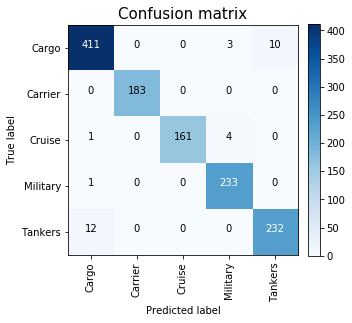

In [200]:
plot_confusion_matrix(val_ground_labels, val_pred, label_cols)

In [201]:
dn_test_df = pd.read_csv('dn121_pr/test_prob.csv')
rnxt_test_df = pd.read_csv('rnxt101_pr/test_prob_tta.csv')
sernxt_test_df = pd.read_csv('sernxt50_pr/test_prob_tta.csv')
# incrn_val_df = pd.read_csv('incrnv2_pr/val_prob_tta.csv')

In [202]:
# add all probs 
test_all_sum =  ((sernxt_test_df[label_cols].values * w[0]) + (dn_test_df[label_cols].values * w[1]) + (rnxt_test_df[label_cols].values * w[2]))/w.sum()

In [203]:
test_pred = pd.Series(test_all_sum.argmax(axis=1)).map(pred_i2c).map(label_mapper_c2i).astype(int)

In [204]:
# image file names
test_img_names = dn_test_df['image'].values

In [205]:
Path('ensemble/').mkdir(exist_ok=True)

In [206]:
# make a submission
pd.DataFrame({'image': test_img_names, 'category': test_pred.values}).to_csv('ensemble/sub_avg1.csv', index=False)